In [38]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Testing SimpleITK loading, windowing, plotting ##

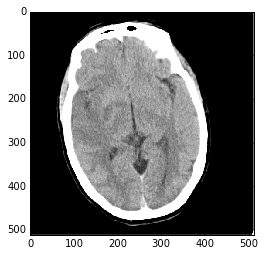

In [17]:
rootDir = 'D:\\AdamHilbert\\DNN_Classification_Project\\data\\'
datasetDir = 'MRCLEAN_CT24h'
patient = '\\0001\\CT24h\\thick\\pat0001.mhd'

path = rootDir + datasetDir + patient

# --- Read Image ---
img = sitk.ReadImage(path)

# --- Load Data ---

center = 30
width = 80

window_filter = sitk.IntensityWindowingImageFilter()
window_filter.SetWindowMinimum(center - (width / 2))
window_filter.SetWindowMaximum(center + (width / 2))
window_filter.SetOutputMinimum(0)
window_filter.SetOutputMaximum(255)

img_plot = sitk.GetArrayFromImage(window_filter.Execute(img))
plt.imshow(img_plot[13,:,:], cmap='gray', interpolation='none')

## Testing SkullStripping with 2D connected-component analysis ##

In [39]:
import skullStripping2D as ss

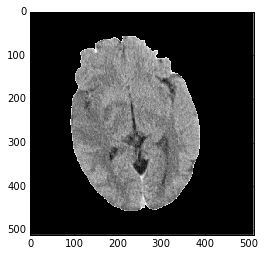

In [6]:
stripped = ss.skullstripping(path)

plt.imshow(stripped[13,:,:], cmap='gray', interpolation='none')

## Testing utils.py reading datasets and retrieving random batches

In [92]:
from __future__ import division

import os
import SimpleITK as sitk
import numpy as np
import openpyxl as ox

def dense_to_one_hot(labels_dense, num_classes):
    """
    Convert class labels from scalars to one-hot vectors.
    Args:
    labels_dense: Dense labels.
    num_classes: Number of classes.

    Outputs:
    labels_one_hot: One-hot encoding for labels.
    """

    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1

    return labels_one_hot

def preprocess_data(X_raw):

    X = X_raw.copy()

    # Substract the mean
    mean_image = np.mean(X, axis=0)
    X -= mean_image

    return X

def read_datasets(data_dir, images_root_sub, image_sub, label_root_sub, label_filename, validation_ratio=0.3, preprocess=False):
    """
    Function to read up images and labels.
    Store only paths as images would fit to memory.

    MRS@90 hardcoded as label attribute in label_filename -> column 'AE'
    """

    followid_attribute = 'AB2:AB501'
    label_attribute = 'AE2:AE501'

    # --- Retrieve all patients we have images from ---
    patients = [name for name in os.listdir(data_dir + images_root_sub)
                    if os.path.isdir(os.path.join(data_dir + images_root_sub, name))]
    # image_sub = "CT24h\\thick\\"
    all_samples = len(patients)

    # --- Store image paths ---
    all_images = np.array([data_dir + images_root_sub + name.zfill(4) + '\\' + image_sub + 'result_resampled.mhd' # 'pat' + name.zfill(4) + '.mhd' \
                                    for name in patients ])

    # --- Load labels from file ---
    labels_wb = ox.load_workbook(data_dir + label_root_sub + label_filename)
    labels_ws = labels_wb.active

    label_dict = {key[0].value.zfill(4): value[0].value 
                                for (key, value) in zip(labels_ws[followid_attribute], labels_ws[label_attribute]) }

    labels = np.array( [ label_dict[name] for name in patients] )

    # --- Preprocess if desired ---
    if preprocess:
        images = preprocess_data(images)

    # --- Shuffle examples to split fairly ---	
    perm = np.arange(all_samples)
    np.random.shuffle(perm)

    all_images = all_images[perm]
    labels = labels[perm]
    
    # rounding instead?
    validation_size = int(all_samples*validation_ratio)

    # --- Split data to training and validation set ---
    validation_images = all_images[:validation_size]
    validation_labels = labels[:validation_size]
    training_images = all_images[validation_size:]
    training_labels = labels[validation_size:]

    num_classes = len(np.unique(labels))

    training_labels = dense_to_one_hot(training_labels, num_classes)
    validation_labels = dense_to_one_hot(validation_labels, num_classes)

    # --- Return 2 DataSet objects for training and validation set ---	
    return DataSet(np.array(training_images), np.array(training_labels)), \
                    DataSet(np.array(validation_images), np.array(validation_labels))



class DataSet(object):
    """
    Utility class to handle dataset structure.
    """
    def __init__(self, images, labels):
        """
        Builds dataset with images and labels.
        Args:
                images: Images data.
                labels: Labels data
        """
        assert images.shape[0] == labels.shape[0], (
                                "images.shape: {0}, labels.shape: {1}".format(str(images.shape), str(labels.shape)))

        self._num_examples = images.shape[0]
        self._images = images
        self._labels = labels
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    @property
    def index_in_epoch(self):
            return self._index_in_epoch


    def next_batch(self, batch_size):
        """
        Return the next `batch_size` examples from this data set.
        Args:
                batch_size: Batch size.
        """
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            self._epochs_completed += 1

            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm]

            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples

        end = self._index_in_epoch

        image_batch = np.array([ \
                sitk.GetArrayFromImage(sitk.ReadImage(image_path))[11:23,16:240,16:240] \
                        for image_path in self._images[start:end]])
        label_batch = self._labels[start:end]

        image_batch = np.swapaxes(image_batch, 1, 2)
        image_batch = np.swapaxes(image_batch, 2, 3)

        return image_batch, label_batch


In [72]:
data_dir = 'D:\\AdamHilbert\\DNN_Classification_Project\\data\\'
images_root_sub = 'MRCLEAN_CT24h\\'
image_sub = 'CT24h\\thick\\alignedRigid\\'

label_root_sub = 'MRCLEAN\\'
label_filename = 'MRCLEAN_MRSDICH.xlsx'

Training_Set, Validation_Set = read_datasets(data_dir, images_root_sub, image_sub, label_root_sub, label_filename)



(5L, 224L, 224L, 12L)
[[ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]]


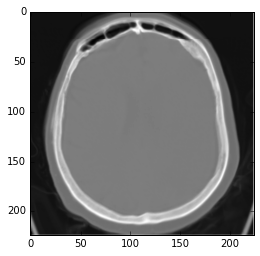

In [90]:

images, labels = Validation_Set.next_batch(5)

print(np.shape(images))
print(labels)

batch_sample = images[1]

plt.imshow(batch_sample[:,:,0], cmap='gray', interpolation='none')